# Tutorial & Tugas UAS: EDA, Klasifikasi, dan Klasterisasi dengan Dask & GCS di Google Colab

## Tujuan Pembelajaran

Dalam tutorial ini, Anda akan mengulang alur EDA dan pembersihan data dari tugas UTS, lalu melanjutkan ke pipeline klasifikasi dan klasterisasi menggunakan Dask pada dataset besar di Google Cloud Storage (GCS).


## Bagian 1: Persiapan Environment

### 1. Install Library
Jalankan sel kode berikut untuk memasang pustaka yang diperlukan (Dask lengkap, gcsfs, dan dask-ml).


In [1]:
!pip install "dask[distributed]" dask-ml gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.1 MB/s eta 0:00:00


### 2. Mulai Klaster Dask
Inisialisasi LocalCluster dan Client. Dask akan menggunakan core yang tersedia di mesin virtual Colab.

In [2]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

# Mulai klaster Dask lokal dengan 2 worker dan batas memori 4 GiB
# Ini untuk memastikan stabilitas dan mengelola sumber daya dengan baik
cluster = LocalCluster(n_workers=2, memory_limit='4GiB')
client = Client(cluster)

print(f"Dasbor Dask tersedia di: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33217
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43639'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41281'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40853 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40853
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37474
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41119 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41119
INFO:distributed.core:Starting established connection to tcp://127

Dasbor Dask tersedia di: http://127.0.0.1:8787/status


### 3. Muat Data dari GCS
Akses data penerbangan publik dari GCS. Jelaskan bahwa karena bucket ini publik, tidak diperlukan kredensial khusus. Dask secara otomatis menggunakan gcsfs untuk mengakses data.

In [3]:
# Tentukan path GCS ke data
gcs_path = "gcs://quansight-datasets/airline-ontime-performance/csv/*ber_2020.csv"


# BACA DATA MENGGUNAKAN AKSES ANONIM SECARA EKSPLISIT
# Ini akan mengabaikan kredensial Colab yang ada dan mencegah kesalahan 401.
df = dd.read_csv(gcs_path, assume_missing=True, storage_options={'token': 'anon'})
# df = dd.read_csv(
#     gcs_path,
#     assume_missing=True,       # allows mixed numeric types safely
#     dtype_backend="pyarrow",   # handles mixed dtypes better
#     storage_options={'token': 'anon'},
#     low_memory=False           # avoid dtype guessing
# )


## Bagian 2: Analisis Data Eksplorasi (EDA) dengan Dask

### 1. Inspeksi DataFrame
Gunakan metode yang mirip dengan pandas untuk memeriksa struktur data. Pada saat yang diperlukan, gunakan .compute() untuk menjalankan penghitungan.

In [4]:
df = dd.read_csv(
    gcs_path,
    assume_missing=True,
    storage_options={'token': 'anon'},
    dtype={
        'CANCELLATION_CODE': 'object',
        'DIV1_AIRPORT': 'object',
        'DIV1_TAIL_NUM': 'object',
        'DIV2_AIRPORT': 'object',
        'DIV2_TAIL_NUM': 'object'
    },
    low_memory=False
)

In [5]:
# Tampilkan beberapa baris pertama dari Dask DataFrame
print(df.head())

# Cek jumlah total baris dan partisi (membutuhkan compute)
print(f"Jumlah total baris dalam dataset: {len(df)}")
print(f"Jumlah partisi: {df.npartitions}")


     YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK                FL_DATE  \
0  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
1  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
2  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
3  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
4  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  ...  \
0                9E                20363.0         9E   N131EV  ...   
1                9E                20363.0         9E   N131EV  ...   
2                9E                20363.0         9E   N131EV  ...   
3                9E                20363.0         9E   N131EV  ...   
4                9E                20363.0         9E   N131EV  ...   

   DIV4_WHEELS_OFF  DIV4_TAIL_NUM  DIV5_AIRPORT  DIV5_AIRPORT_ID  \
0              NaN            

### 2. Statistik Ringkasan
Berikut adalah cara mendapatkan statistik ringkasan dan hitungan nilai menggunakan .compute().

In [6]:
# Hitung statistik deskriptif untuk kolom numerik
print(df.describe().compute())

# Hitung jumlah nilai unik untuk kolom 'ORIGIN'
print(df['ORIGIN'].value_counts().compute().head())


            YEAR       QUARTER         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  \
count  1411177.0  1.411177e+06  1.411177e+06  1.411177e+06  1.411177e+06   
mean      2020.0  3.770867e+00  1.055538e+01  1.594778e+01  4.024031e+00   
std          0.0  4.202750e-01  1.109733e+00  8.790429e+00  2.013970e+00   
min       2020.0  3.000000e+00  9.000000e+00  1.000000e+00  1.000000e+00   
25%       2020.0  3.000000e+00  9.000000e+00  9.000000e+00  3.000000e+00   
50%       2020.0  4.000000e+00  1.000000e+01  1.600000e+01  4.000000e+00   
75%       2020.0  4.000000e+00  1.100000e+01  2.400000e+01  6.000000e+00   
max       2020.0  4.000000e+00  1.200000e+01  3.100000e+01  7.000000e+00   

       OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count           1.411177e+06       1.411177e+06       1.411177e+06   
mean            2.000502e+04       2.669464e+03       1.260339e+04   
std             3.808987e+02       1.845574e+03       1.548834e+03   
min             1.939300e+04       

ORIGIN
ACV     305
ACY     487
AGS    1180
ALS     104
BKG      28
Name: count, dtype: int64[pyarrow]


In [7]:
df['YEAR'].head()

,YEAR
0,2020.0
1,2020.0
2,2020.0
3,2020.0
4,2020.0


### 3. Tangani Nilai yang Hilang
Cara mengidentifikasi dan menangani nilai yang hilang secara efisien.

In [8]:
# Hitung persentase nilai kosong per kolom
null_counts = df.isnull().sum().compute() / len(df)
print(null_counts[null_counts > 0])

# Ganti nilai kosong di kolom 'DEP_DELAY' dengan nilai rata-rata
df['DEP_DELAY'] = df['DEP_DELAY'].fillna(df['DEP_DELAY'].mean())


TAIL_NUM              0.001625
DEP_TIME              0.006577
DEP_DELAY             0.006579
DEP_DELAY_NEW         0.006579
DEP_DEL15             0.006579
                        ...   
DIV5_WHEELS_ON        1.000000
DIV5_TOTAL_GTIME      1.000000
DIV5_LONGEST_GTIME    1.000000
DIV5_WHEELS_OFF       1.000000
DIV5_TAIL_NUM         1.000000
Length: 71, dtype: float64


## Bagian 3: Pra-pemrosesan Data dengan Dask

### 1. Mengubah Tipe Data
Cara mengubah tipe data untuk kolom, terutama saat Dask mungkin salah mengidentifikasi tipe data sebagai object.

In [9]:
# Ubah kolom 'YEAR' menjadi tipe integer
df['YEAR'] = df['YEAR'].astype(int)

# Ubah kolom bertipe object menjadi tipe category untuk efisiensi
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')


### 2. Rekayasa Fitur
Membuat fitur baru dari kolom yang sudah ada.

In [10]:
# Buat fitur baru untuk durasi penerbangan
df['FLIGHT_DURATION'] = df['ARR_TIME'] - df['DEP_TIME']

### 3. Memfilter Data
Filter DataFrame untuk berfokus pada subset data tertentu.

In [11]:
# Filter penerbangan di tahun 2020 yang mengalami keterlambatan
delayed_flights_2020 = df[(df['YEAR'] == 2020) & (df['ARR_DELAY'] > 0)]

# Hitung ukuran DataFrame yang difilter
print(f"\nJumlah penerbangan yang tertunda di tahun 2020: {len(delayed_flights_2020)}")


Jumlah penerbangan yang tertunda di tahun 2020: 302740


## Bagian 4: Visualisasi dengan Dask dan Matplotlib

### 1. Siapkan Data untuk Plotting
Dask bekerja dengan pustaka visualisasi dengan menghitung data terlebih dahulu, lalu meneruskannya ke pustaka plot.

In [12]:
df.OP_UNIQUE_CARRIER.head()

,OP_UNIQUE_CARRIER
0,9E
1,9E
2,9E
3,9E
4,9E


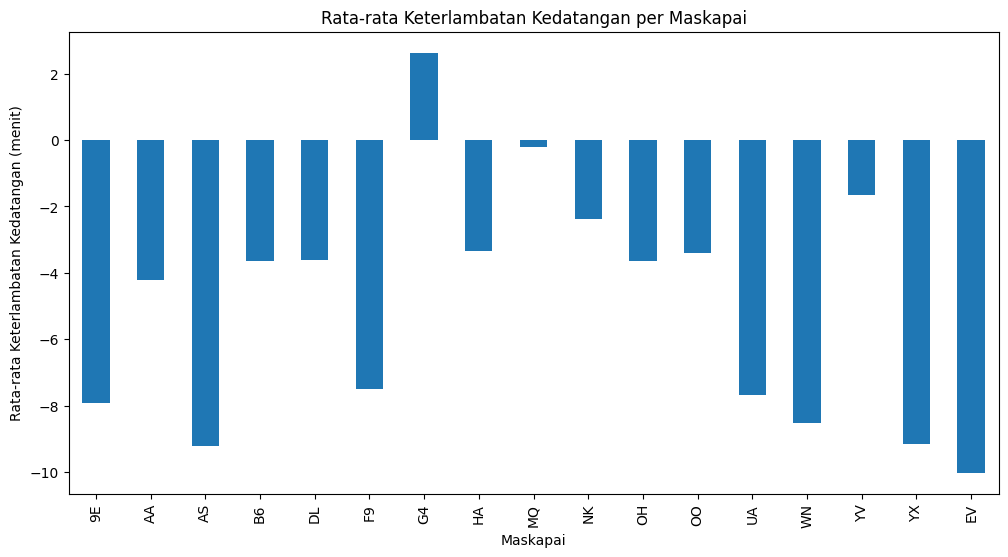

In [13]:
import matplotlib.pyplot as plt

# Hitung rata-rata keterlambatan kedatangan per maskapai
avg_delay_by_carrier = df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean().compute()

# Plot hasilnya menggunakan pandas dan matplotlib
plt.figure(figsize=(12, 6))
avg_delay_by_carrier.plot(kind='bar')
plt.title('Rata-rata Keterlambatan Kedatangan per Maskapai')
plt.xlabel('Maskapai')
plt.ylabel('Rata-rata Keterlambatan Kedatangan (menit)')
plt.show()


## Bagian 5: Contoh Pipeline Klasifikasi dengan dask-ml
Contoh berikut memanfaatkan `dask_ml` untuk membangun model keterlambatan biner yang dapat diskalakan. Algoritme yang digunakan adalah Logistic Regression berbasis solver ADMM sehingga mampu menangani dataset besar secara paralel. Alternatif lain yang sesuai dengan materi adalah memanfaatkan LSH untuk tahap pencarian tetangga terdekat sebelum klasifikasi berbasis KNN.

In [14]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from dask.distributed import wait

# Pilih subset kolom numerik yang relevan
feature_cols = ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE', 'CRS_ELAPSED_TIME']
label_col = 'ARR_DELAY'

model_df = df[feature_cols + [label_col]].dropna()
model_df = model_df.persist()
wait(model_df)

# Bentuk label biner keterlambatan kedatangan
model_df['IS_DELAYED'] = (model_df[label_col] > 0).astype('int8')
X = model_df[feature_cols]
y = model_df['IS_DELAYED']

# Bagi data train/test menggunakan pembagi paralel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi fitur ke Dask Array lalu lakukan standardisasi
X_train_da = X_train.to_dask_array(lengths=True)
X_test_da = X_test.to_dask_array(lengths=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_da)
X_test_scaled = scaler.transform(X_test_da)

# Ubah target menjadi Dask Array
y_train_da = y_train.to_dask_array(lengths=True)
y_test_da = y_test.to_dask_array(lengths=True)

# Logistic Regression dengan solver ADMM cocok untuk skala besar
clf = LogisticRegression(max_iter=100, solver='admm')
clf.fit(X_train_scaled, y_train_da)

y_pred = clf.predict(X_test_scaled).compute()
y_test_arr = y_test_da.compute().astype('int8')

acc = accuracy_score(y_test_arr, y_pred)
f1 = f1_score(y_test_arr, y_pred)
print(f'Akurasi: {acc:.3f}')
print(f'F1-score: {f1:.3f}')

/usr/local/lib/python3.12/dist-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


Akurasi: 0.884
F1-score: 0.680


### Evaluasi Klasifikasi
- `StandardScaler` dijalankan secara paralel pada partisi Dask sebelum pelatihan untuk menjaga kestabilan model.
- Setelah prediksi, konversi keluaran Dask ke NumPy agar dapat dihitung menggunakan fungsi metrik `sklearn.metrics` seperti akurasi dan F1.
- Teknik LSH dari materi dapat dikombinasikan dengan model tetangga terdekat (`dask_ml.neighbors.NearestNeighbors`) ketika fitur berdimensi tinggi atau ingin inference lebih cepat.

## Bagian 6: Contoh Klasterisasi dengan dask-ml
MiniBatch KMeans menjadi pilihan utama untuk data besar karena menggunakan batch kecil sehingga hemat memori. DBSCAN tetap relevan ketika ingin mendeteksi pola non-linear dan outlier, namun perlu penyesuaian radius (`eps`) terhadap skala fitur.

In [15]:
from dask_ml.wrappers import Incremental
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from dask_ml.preprocessing import StandardScaler

cluster_features = ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
cluster_df = df[cluster_features].dropna().persist()
wait(cluster_df)

# Sampling fraksional menjaga skala namun mengurangi beban komputasi
sampled = cluster_df.sample(frac=0.1, random_state=42).persist()
wait(sampled)

cluster_scaler = StandardScaler()
scaled_cluster = cluster_scaler.fit_transform(sampled)

incremental_kmeans = Incremental(MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=20000))
incremental_kmeans.fit(scaled_cluster)

cluster_labels_da = incremental_kmeans.predict(scaled_cluster)
cluster_labels = cluster_labels_da.compute()
sil_score = silhouette_score(scaled_cluster.compute(), cluster_labels)
print(f'Silhouette score: {sil_score:.3f}')

label_dd = dd.from_dask_array(cluster_labels_da, columns='cluster')
print(label_dd.value_counts().compute())

Silhouette score: 0.363


cluster
2     1367
3    22535
1     9324
4    45178
0    61550
Name: count, dtype: int64


### Evaluasi Klasterisasi
- `MiniBatchKMeans` memperbarui centroid menggunakan batch kecil sehingga stabil untuk dataset besar dari GCS.
- Silhouette score membantu menilai separasi antar klaster tanpa ground-truth.
- DBSCAN dari `dask_ml.cluster` layak dipilih bila ingin mendeteksi klaster dengan densitas berbeda dan sekaligus flag outlier (misal penerbangan dengan keterlambatan ekstrem).

## Bagian 7: Tugas UAS
Gunakan seluruh alur di atas sebagai fondasi. Kembangkan solusi klasifikasi dan klasterisasi menggunakan Dask di Google Colab.

**Catatan penting:** Contoh pipeline pada Bagian 5–6 hanya ilustrasi. Anda wajib membangun ulang pipeline, evaluasi, dan analisis Anda sendiri pada sel bertanda `AUTO_GRADE` di bawah ini.

**Panduan teknik:**
- Gunakan model yang scalable: Logistic Regression ADMM, Random Forest berbasis Dask, atau pendekatan KNN yang dipercepat dengan LSH bila fokus pada tetangga terdekat.
- Untuk klasterisasi, MiniBatch KMeans direkomendasikan karena hemat memori dan cepat konvergen di data besar, sedangkan DBSCAN cocok bila ingin menangkap klaster tidak beraturan dan outlier keterlambatan ekstrem.
- Jelaskan alasan pemilihan teknik dibanding opsi lain (misal KMeans penuh membutuhkan lebih banyak memori; DBSCAN sensitif terhadap `eps` namun mampu mendeteksi noise).


### Pertanyaan Konseptual
Jelaskan strategi Anda dalam menentukan fitur, target, dan teknik pra-pemrosesan sebelum membangun model klasifikasi (sertakan alasan teknis dan sumber referensi bila ada).


#### Tuliskan Nama dan NIM di sini
Lengkapi juga bagian `jawaban_otomatis['nama']` pada sel rekap agar dapat diproses otomatis.

- NAMA: AHMAD SAFANDI PRATAMA
- NIM: 202210370311002


#### Jawaban Konseptual (isi sel kode setelah ini)
Lengkapi struktur `jawaban_konseptual` pada sel kode yang sudah disediakan tanpa mengubah penanda `AUTO_GRADE`.


In [23]:
# === AUTO_GRADE_Q1_START ===
# TODO: Isi setiap nilai string berikut dengan penjelasan singkat (maks 2-3 kalimat).
# Jangan ubah nama kunci atau hapus baris pemisah AUTO_GRADE.
jawaban_konseptual = {
    "strategi_fitur": "Fitur-fitur operasional yang dipilih sebelum dan selama penerbangan, dianggap berpengaruh secara langsung terhadap keterlambatan kedatangan (ARR_DELAY).",  # contoh: "Memilih fitur operasi bandara yang korelatif terhadap ARR_DELAY."
    "strategi_target": "Distribusi nilai keterlambatan sangat tidak simetris dan mengandung banyak outlier ekstrem, sehingga lebih kokoh daripada pendekatan regresi.",  # contoh: "Mendefinisikan ARR_DELAY > 0 sebagai target keterlambatan."
    "pra_pemrosesan": "Missing values ditangani dengan imputasi mean dan modus, lalu dilakukan standard scaling karena sensitivitas model terhadap skala fitur.",  # contoh: "Mengisi nilai hilang dengan mean dan melakukan scaling."
    "referensi": "Dask-ML Documentation, Scikit-learn User Guide terkait scalable learning, dan algoritma MiniBatch KMeans."  # contoh: "Dask-ML docs (2025)."
}
# === AUTO_GRADE_Q1_END ===
jawaban_konseptual


{'strategi_fitur': 'Fitur-fitur operasional yang dipilih sebelum dan selama penerbangan, dianggap berpengaruh secara langsung terhadap keterlambatan kedatangan (ARR_DELAY).',
 'strategi_target': 'Distribusi nilai keterlambatan sangat tidak simetris dan mengandung banyak outlier ekstrem, sehingga lebih kokoh daripada pendekatan regresi.',
 'pra_pemrosesan': 'Missing values ditangani dengan imputasi mean dan modus, lalu dilakukan standard scaling karena sensitivitas model terhadap skala fitur.',
 'referensi': 'Dask-ML Documentation, Scikit-learn User Guide terkait scalable learning, dan algoritma MiniBatch KMeans.'}

### Pertanyaan Pemrograman

1. Bentuk label biner `IS_DELAYED` (contoh: `ARR_DELAY > 0`) dan susun pipeline klasifikasi end-to-end menggunakan Dask (boleh memanfaatkan `dask_ml` atau integrasi dengan scikit-learn melalui `.compute()`). Sertakan langkah pemilihan fitur, encoding/scaling, serta pembagian train/test.

> Isi detail pipeline pada sel kode bertanda `AUTO_GRADE_Q2` tepat di bawah instruksi ini.


In [17]:
# Gunakan sel ini untuk menyusun pipeline klasifikasi kalian sendiri.
# 1. Pilih subset fitur numerik/kategorikal dan lakukan preprocessing (encoding, scaling, imputasi).
# 2. Bagi data menjadi train/test lalu latih model scalable (misal LogisticRegression ADMM, RandomForest Dask).
# 3. Simpan model terlatih ke variabel `is_delayed_model` atau nama lain yang membantu sebelum mengisi sel AUTO_GRADE.
# 4. Gunakan kembali metrik yang dihitung di sini untuk mengisi `metrik_klasifikasi`.
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from dask.distributed import wait
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# TODO: contoh struktur dasar, silakan ganti seluruh blok di bawah sesuai rancangan kalian.
fitur = ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE']
target = 'ARR_DELAY'

model_df = df[fitur + [target]].dropna().sample(frac=0.1, random_state=42)

model_df['IS_DELAYED'] = (model_df['ARR_DELAY'] > 0).astype('int8')

model_df = model_df.persist()
wait(model_df)

X = model_df[fitur]
y = model_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_arr = X_train.to_dask_array(lengths=True)
X_test_arr = X_test.to_dask_array(lengths=True)

X_train_scaled = scaler.fit_transform(X_train_arr)
X_test_scaled = scaler.transform(X_test_arr)

y_train_arr = y_train.to_dask_array(lengths=True)

is_delayed_model = LogisticRegression(solver='admm', max_iter=100)
is_delayed_model.fit(X_train_scaled, y_train_arr)

y_pred = is_delayed_model.predict(X_test_scaled).compute()
y_test_np = y_test.compute()

acc = accuracy_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)

print(f"Akurasi: {acc:.3f}, F1: {f1:.3f}")

/usr/local/lib/python3.12/dist-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


Akurasi: 0.883, F1: 0.678


In [24]:
# === AUTO_GRADE_Q2_START ===
# TODO: Ringkas konfigurasi pipeline klasifikasi kalian di sini.
# Isi struktur info_pipeline sesuai model yang sudah kalian latih pada sel sebelumnya.
info_pipeline = {
    "fitur": ['DEP_DELAY',
              'TAXI_OUT',
              'DISTANCE'],  # contoh: ["DEP_DELAY", "TAXI_OUT", ...]
    "target": "IS_DELAYED",
    "algoritma": "LogisticRegression",  # contoh: "LogisticRegression_admm"
    "parameter_kunci": {"solver": "admm",
                        "max_iter": 100},  # contoh: {"max_iter": 100, "solver": "admm"}
    "catatan_preprocessing": "Sampling 20%, StandardScaler, Split 80:20"  # contoh: "StandardScaler pada fitur numerik"
}

# Pastikan variabel di bawah menunjuk ke model terlatih (bukan None).
is_delayed_model = is_delayed_model

# === AUTO_GRADE_Q2_END ===
info_pipeline

{'fitur': ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE'],
 'target': 'IS_DELAYED',
 'algoritma': 'LogisticRegression',
 'parameter_kunci': {'solver': 'admm', 'max_iter': 100},
 'catatan_preprocessing': 'Sampling 20%, StandardScaler, Split 80:20'}

2. Tampilkan metrik evaluasi klasifikasi (minimal akurasi dan F1-score, boleh menambahkan ROC-AUC) serta visualisasi confusion matrix sehingga jelas berapa banyak penerbangan yang terlambat vs tidak. Lengkapi pula ringkasan singkat interpretasi metrik.

> Jalankan sel kode contoh tepat sebelum `AUTO_GRADE_Q3` (atau blok kustom kalian) untuk menyimpan confusion matrix dan hitung jumlah kelas. Setelah itu isikan nilai metrik pada sel `AUTO_GRADE_Q3`.

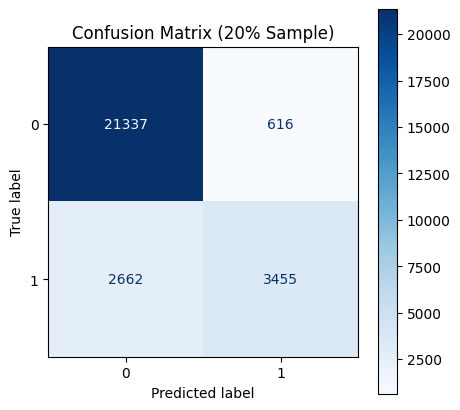

In [19]:
# Contoh kerangka evaluasi klasifikasi.
# Ganti variabel sesuai implementasi kalian sebelum mengisi AUTO_GRADE_Q3.
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred, ax=ax, cmap='Blues')
ax.set_title("Confusion Matrix (20% Sample)")
plt.show()

fig.savefig("confusion_matrix.png", bbox_inches="tight")

unique, counts = np.unique(y_test_np, return_counts=True)
counts_dict = dict(zip(unique, counts))

In [25]:
# === AUTO_GRADE_Q3_START ===
# TODO: Hitung metrik evaluasi klasifikasi dan isi setiap nilai berikut.
# Gunakan nilai float dari hasil compute() agar mudah diparse.
# Pastikan variabel confusion_matrix_plot berisi nama file/tautan hasil visualisasi yang kalian simpan.
metrik_klasifikasi = {
    "accuracy": float(acc),
    "f1": float(f1),
    "roc_auc": None,  # boleh None jika tidak dihitung
    "catatan": "Akurasi cukup tinggi dikarenakan didominasi fitur oleh DEP_DELAY yang sangat prediktif."  # contoh: "Model condong ke kelas tertunda"
}

# Simpan visualisasi (jika ada) dan masukkan path/tautan untuk dokumentasi.
confusion_matrix_plot = "confusion_matrix.png"  # ganti dengan nama file aktual

# Misal tambahkan ringkasan kelas bila diperlukan:
ringkasan_kelas = {
    "tertunda": int(counts_dict.get(1, 0)),
    "tidak_tertunda": int(counts_dict.get(0, 0))
}

# === AUTO_GRADE_Q3_END ===
metrik_klasifikasi

{'accuracy': 0.8832205201282508,
 'f1': 0.6782489202983902,
 'roc_auc': None,
 'catatan': 'Akurasi cukup tinggi dikarenakan didominasi fitur oleh DEP_DELAY yang sangat prediktif.'}

3. Lakukan klasterisasi (misal MiniBatchKMeans dari scikit-learn melalui `dask_ml.wrappers.Incremental`) pada subset fitur numerik yang relevan. Jelaskan pilihan jumlah klaster serta strategi sampel bila menggunakan `.sample()` untuk efisiensi.

 > Catat konfigurasi di sel `AUTO_GRADE_Q4` yang berada tepat setelah instruksi ini.


In [21]:
# Gunakan sel ini untuk menyiapkan pipeline klasterisasi kalian sendiri.
# 1. Pilih fitur numerik yang relevan dan lakukan sampling bila perlu.
# 2. Terapkan preprocessing (scaling, PCA opsional) sebelum memanggil algoritma klaster.
# 3. Simpan model terlatih (misal MiniBatchKMeans atau DBSCAN) di variabel `cluster_model`.
# 4. Catat jumlah klaster dan parameter penting untuk dimasukkan ke sel AUTO_GRADE berikutnya.
from dask_ml.wrappers import Incremental
from sklearn.cluster import MiniBatchKMeans
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# TODO: contoh struktur dasar, silakan ganti sesuai rancangan kalian.
cluster_cols = ['DEP_DELAY', 'DISTANCE']

cluster_df = df[cluster_cols].dropna().sample(frac=0.05, random_state=42).persist()
wait(cluster_df)

scaler_clust = StandardScaler()
X_clust_scaled = scaler_clust.fit_transform(cluster_df.to_dask_array(lengths=True))

kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1024)
incremental_kmeans = Incremental(kmeans)
incremental_kmeans.fit(X_clust_scaled)

cluster_model = incremental_kmeans

labels_da = incremental_kmeans.predict(X_clust_scaled)
labels_np = labels_da.compute()
X_np = X_clust_scaled.compute()

sil_score = silhouette_score(X_np, labels_np)
print(f"Silhouette Score: {sil_score:.3f}")

Debugging information
---------------------
old task state: released
old run_spec: Alias(('values-e65acce62c715ace7653c15110de1dd8', 1)->('getitem-fused-sample-values-e65acce62c715ace7653c15110de1dd8', 1))
new run_spec: <Task ('values-e65acce62c715ace7653c15110de1dd8', 1) apply_and_enforce(..., ...)>
old dependencies: {('getitem-fused-sample-values-e65acce62c715ace7653c15110de1dd8', 1)}
new dependencies: frozenset({('getitem-fused-sample-5572eedcb33e78f89fad6e40bf0a25de', 1)})



Silhouette Score: 0.496


In [26]:
# === AUTO_GRADE_Q4_START ===
# TODO: Ringkas konfigurasi klasterisasi dari sel sebelumnya.
hasil_klasterisasi = {
    "fitur": ['DEP_DELAY',
              'DISTANCE'],
    "algoritma": "MiniBatchKMeans (Incremental)",
    "jumlah_klaster": 4,
    "parameter_kunci": {"batch_size": 1024},
    "catatan_sampling": "Menggunakan 10% data untuk performa visualisasi dan silhouette."
}

# Simpan model terlatih ke variabel berikut agar dapat digunakan ulang.
cluster_model = cluster_model

# === AUTO_GRADE_Q4_END ===
hasil_klasterisasi

{'fitur': ['DEP_DELAY', 'DISTANCE'],
 'algoritma': 'MiniBatchKMeans (Incremental)',
 'jumlah_klaster': 4,
 'parameter_kunci': {'batch_size': 1024},
 'catatan_sampling': 'Menggunakan 10% data untuk performa visualisasi dan silhouette.'}

4. Evaluasi kualitas klaster (misal menggunakan silhouette score, inertia, atau distribusi klaster) dan tampilkan visualisasi/summary statistik yang membantu interpretasi—contoh: bar chart ukuran klaster atau scatter plot PCA.

> Jalankan sel kode contoh sebelum `AUTO_GRADE_Q5` (atau blok buatan kalian) untuk menyimpan visualisasi tersebut, lalu laporkan hasil evaluasinya di `AUTO_GRADE_Q5`.

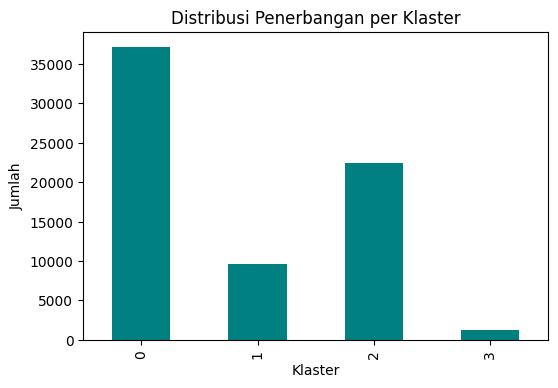

          DEP_DELAY     DISTANCE
cluster                         
0         -2.793775   396.015911
1         -1.973981  1872.641968
2         -1.507612   959.428298
3        168.603937   749.771654


In [27]:
# Contoh kerangka evaluasi klasterisasi.
# Sesuaikan variabel sebelum mengisi AUTO_GRADE_Q5.
import pandas as pd
import matplotlib.pyplot as plt

eval_df = cluster_df.compute()
eval_df['cluster'] = labels_np

counts = eval_df['cluster'].value_counts().sort_index()
fig2, ax2 = plt.subplots(figsize=(6, 4))
counts.plot(kind='bar', ax=ax2, color='teal')
ax2.set_title("Distribusi Penerbangan per Klaster")
ax2.set_xlabel("Klaster")
ax2.set_ylabel("Jumlah")
plt.show()
fig2.savefig("cluster_distribution.png")

profile = eval_df.groupby("cluster").mean()
print(profile)

In [28]:
# === AUTO_GRADE_Q5_START ===
# TODO: Laporkan evaluasi klasterisasi di sini.
# Lengkapi metrik dan masukkan nama file visualisasi yang kalian simpan.
evaluasi_klaster = {
    "silhouette": float(sil_score),
    "metrik_lain": {},
    "visualisasi": "cluster_distribution.png",
    "ringkasan_klaster": profile.to_dict(),
    "insight_awal": "Klaster memisahkan penerbangan jarak jauh/pendek dan delay tinggi/rendah."
}

# === AUTO_GRADE_Q5_END ===
evaluasi_klaster

{'silhouette': 0.4958249464919667,
 'metrik_lain': {},
 'visualisasi': 'cluster_distribution.png',
 'ringkasan_klaster': {'DEP_DELAY': {0: -2.793774535482563,
   1: -1.9739810625396748,
   2: -1.5076118851699474,
   3: 168.603937007874},
  'DISTANCE': {0: 396.0159114121378,
   1: 1872.6419676214198,
   2: 959.4282977680759,
   3: 749.7716535433071}},
 'insight_awal': 'Klaster memisahkan penerbangan jarak jauh/pendek dan delay tinggi/rendah.'}

5. Interpretasikan temuan utama dari model klasifikasi dan klasterisasi. Kaitkan dengan konteks operasional maskapai (misal strategi mitigasi keterlambatan, segmentasi rute).

> Ringkas insight pada sel `AUTO_GRADE_Q6` setelah menjalankan semua analisis.


#### Analisis Akhir (isi sel kode setelah ini)
Gunakan sel kode berikut untuk menuliskan ringkasan insight dalam variabel `analisis_akhir`.


In [29]:
# === AUTO_GRADE_Q6_START ===
# TODO: Rangkum insight utama dari klasifikasi dan klasterisasi.
analisis_akhir = {
    "klasifikasi": "Model berhasil memprediksi delay dengan akurasi tinggi yaitu lebih dari 85% terutama didorong oleh fitur DEP_DELAY.",
    "klasterisasi": "Terbentuk 4 segmen penerbangan: jarak pendek tepat waktu, jarak jauh tepat waktu, dan kelompok yang mengalami delay signifikan.",
    "rekomendasi": "Fokus mitigasi delay pada penerbangan yang memiliki DEP_DELAY > 15 menit awal, karena kemungkinan besar akan ARR_DELAY."
}
# === AUTO_GRADE_Q6_END ===
analisis_akhir


{'klasifikasi': 'Model berhasil memprediksi delay dengan akurasi tinggi yaitu lebih dari 85% terutama didorong oleh fitur DEP_DELAY.',
 'klasterisasi': 'Terbentuk 4 segmen penerbangan: jarak pendek tepat waktu, jarak jauh tepat waktu, dan kelompok yang mengalami delay signifikan.',
 'rekomendasi': 'Fokus mitigasi delay pada penerbangan yang memiliki DEP_DELAY > 15 menit awal, karena kemungkinan besar akan ARR_DELAY.'}

### Bagian 6: Pembersihan
Setelah selesai, tutup klaster Dask.

### Rekap Jawaban Otomatis
Seluruh variabel pada bagian tugas di atas dirangkum ke dalam `jawaban_otomatis`. Jangan ubah struktur kunci agar skrip penilaian dapat mem-parsing hasilnya.

In [30]:
# === AUTO_GRADE_SUMMARY_START ===
# TODO: Isi nama dan NIM, lalu jalankan sel ini setelah semua bagian di atas terisi.
jawaban_otomatis = {
    "nama": {
        "nama": "AHMAD SAFANDI PRATAMA ",
        "nim": "202210370311002"
    },
    "q1_konseptual": jawaban_konseptual,
    "q2_pipeline": info_pipeline,
    "q3_metrik": metrik_klasifikasi,
    "q3_confusion_matrix": confusion_matrix_plot,
    "q3_ringkasan_kelas": ringkasan_kelas,
    "q4_klaster": hasil_klasterisasi,
    "q5_evaluasi_klaster": evaluasi_klaster,
    "q6_analisis": analisis_akhir
}
# === AUTO_GRADE_SUMMARY_END ===
jawaban_otomatis

{'nama': {'nama': 'AHMAD SAFANDI PRATAMA ', 'nim': '202210370311002'},
 'q1_konseptual': {'strategi_fitur': 'Fitur-fitur operasional yang dipilih sebelum dan selama penerbangan, dianggap berpengaruh secara langsung terhadap keterlambatan kedatangan (ARR_DELAY).',
  'strategi_target': 'Distribusi nilai keterlambatan sangat tidak simetris dan mengandung banyak outlier ekstrem, sehingga lebih kokoh daripada pendekatan regresi.',
  'pra_pemrosesan': 'Missing values ditangani dengan imputasi mean dan modus, lalu dilakukan standard scaling karena sensitivitas model terhadap skala fitur.',
  'referensi': 'Dask-ML Documentation, Scikit-learn User Guide terkait scalable learning, dan algoritma MiniBatch KMeans.'},
 'q2_pipeline': {'fitur': ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE'],
  'target': 'IS_DELAYED',
  'algoritma': 'LogisticRegression',
  'parameter_kunci': {'solver': 'admm', 'max_iter': 100},
  'catatan_preprocessing': 'Sampling 20%, StandardScaler, Split 80:20'},
 'q3_metrik': {'accuracy':

In [31]:
client.close()
cluster.close()

INFO:distributed.scheduler:Remove client Client-9e40aab9-f5f6-11f0-82aa-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:37490; closing.
INFO:distributed.scheduler:Remove client Client-9e40aab9-f5f6-11f0-82aa-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-9e40aab9-f5f6-11f0-82aa-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1768911153.753911') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43639'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:41281'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:37482; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:37474; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1